## Features engineering for Multi-class Classifier

**Task**: Create a multi-classifier that if a delay has occured, it will predict what is the cause of the delay based off the duration of the delay. 

Steps:

- general cleaning and analysis - remove irrelevant (e.g. `dup`) and redudant (e.g. `origin_airport_id` gives the same information that `origin`, `origin_city_name`, give etc). remove null values.
- filter out the records with arr_delay or dep_delay > 0. (As the classifier is testing the cause AFTER a delay has been confirmed, this is a boundary condition.)  
- modify the dataset so that it can have a "target delay" class, showing what caused the delay. 
- generate features.

This notebook discusses the features engineering process. Find details about model building and testing in ['MultiClass_Classifer](MultiClass_Classifier.ipynb)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)

In [3]:
!pwd

/Users/uche/Documents/Lighthouse Labs/repos/Projects/Project5_Predicting_flight_delays/Modeling/Model_3_Multiclass_Classifier


In [96]:
df = pd.read_csv('../datasets/flights_sample.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159275 entries, 0 to 159274
Data columns (total 43 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Unnamed: 0           159275 non-null  int64  
 1   fl_date              159275 non-null  object 
 2   mkt_unique_carrier   159275 non-null  object 
 3   branded_code_share   159275 non-null  object 
 4   mkt_carrier          159275 non-null  object 
 5   mkt_carrier_fl_num   159275 non-null  int64  
 6   op_unique_carrier    159275 non-null  object 
 7   tail_num             158782 non-null  object 
 8   op_carrier_fl_num    159275 non-null  int64  
 9   origin_airport_id    159275 non-null  int64  
 10  origin               159275 non-null  object 
 11  origin_city_name     159275 non-null  object 
 12  dest_airport_id      159275 non-null  int64  
 13  dest                 159275 non-null  object 
 14  dest_city_name       159275 non-null  object 
 15  crs_dep_time     

In [97]:
# cleaning
# removing unrequired columns
df = df.drop(columns = ['Unnamed: 0', 'wheels_off', 
                    'wheels_on',
                    'diverted',
                    'cancellation_code',
                    'dup',
                    'first_dep_time',
                    'total_add_gtime',
                    'longest_add_gtime',
                    'no_name'])

In [98]:
# check that NaN dep_delay and arr_delay are actually NaN and not 0 delays that were not properly recorded
filter1 = df['dep_delay'].isna()
filter2 = (df['crs_dep_time'] == df['dep_time'])

indices = df[(filter1) & (filter2)].index

for idx in indices:
    df.loc[idx,'dep_delay'] = 0

filter1 = df['arr_delay'].isna()
filter2 = (df['crs_arr_time'] == df['arr_time'])

indices = df[(filter1) & (filter2)].index

for idx in indices:
    df.loc[idx,'arr_delay'] = 0

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159275 entries, 0 to 159274
Data columns (total 33 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   fl_date              159275 non-null  object 
 1   mkt_unique_carrier   159275 non-null  object 
 2   branded_code_share   159275 non-null  object 
 3   mkt_carrier          159275 non-null  object 
 4   mkt_carrier_fl_num   159275 non-null  int64  
 5   op_unique_carrier    159275 non-null  object 
 6   tail_num             158782 non-null  object 
 7   op_carrier_fl_num    159275 non-null  int64  
 8   origin_airport_id    159275 non-null  int64  
 9   origin               159275 non-null  object 
 10  origin_city_name     159275 non-null  object 
 11  dest_airport_id      159275 non-null  int64  
 12  dest                 159275 non-null  object 
 13  dest_city_name       159275 non-null  object 
 14  crs_dep_time         159275 non-null  int64  
 15  dep_time         

In [99]:
# filter out records where there were no delays
df['isDelay'] = df['arr_delay'].apply(lambda x: 1 if x>0 else None)
df['isDepDelay'] = df['dep_delay'].apply(lambda x: 1 if x>0 else None)
df['isDelay'].fillna(df['isDepDelay'], inplace=True)
df.drop(columns=['isDepDelay'], inplace=True)
df.dropna(subset='isDelay', inplace=True)

In [100]:
# select the target labels
delay_cols = ['carrier_delay', 'weather_delay',
   'nas_delay', 'security_delay', 'late_aircraft_delay']
# clean the delay variables, fill with 0, assuming nan delays were 0
for col in delay_cols:
    df[col].fillna(0, inplace=True) 
# defining the target (y) labels
df['target_delay'] = df[delay_cols].idxmax(axis=1) # returns maximum delay

In [101]:
df.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,origin_city_name,dest_airport_id,dest,dest_city_name,crs_dep_time,dep_time,dep_delay,taxi_out,taxi_in,crs_arr_time,arr_time,arr_delay,cancelled,crs_elapsed_time,actual_elapsed_time,air_time,flights,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,isDelay,target_delay
1,2019-05-25,AS,AS,AS,1438,AS,N844VA,1438,12892,LAX,"Los Angeles, CA",14831,SJC,"San Jose, CA",2005,2058.0,53.0,27.0,3.0,2130,2223.0,53.0,0,85.0,85.0,55.0,1,308,16.0,0.0,0.0,0.0,37.0,1.0,late_aircraft_delay
5,2018-07-22,AA,AA_CODESHARE,AA,3499,MQ,N820AE,3499,11066,CMH,"Columbus, OH",12953,LGA,"New York, NY",910,920.0,10.0,19.0,8.0,1100,1109.0,9.0,0,110.0,109.0,82.0,1,479,0.0,0.0,0.0,0.0,0.0,1.0,carrier_delay
7,2019-11-27,WN,WN,WN,892,WN,N465WN,892,10397,ATL,"Atlanta, GA",12451,JAX,"Jacksonville, FL",1955,2011.0,16.0,13.0,4.0,2100,2111.0,11.0,0,65.0,60.0,43.0,1,270,0.0,0.0,0.0,0.0,0.0,1.0,carrier_delay
10,2019-01-10,UA,UA,UA,2342,UA,N834UA,2342,14492,RDU,"Raleigh/Durham, NC",11618,EWR,"Newark, NJ",1805,2034.0,149.0,34.0,7.0,1957,2226.0,149.0,0,112.0,112.0,71.0,1,416,0.0,0.0,149.0,0.0,0.0,1.0,nas_delay
12,2019-11-20,DL,DL,DL,1142,DL,N847DN,1142,14057,PDX,"Portland, OR",14869,SLC,"Salt Lake City, UT",1858,1852.0,-6.0,9.0,29.0,2145,2201.0,16.0,0,107.0,129.0,91.0,1,630,0.0,0.0,16.0,0.0,0.0,1.0,nas_delay


In [102]:
# remove more unneeded columns
unneeded_cols = ['origin', 'origin_city_name', 'dest', 'dest_city_name',
                'dep_time', 'taxi_out', 'taxi_in', 'arr_time', 'cancelled',
                'actual_elapsed_time', 'flights', 'isDelay']
df.drop(columns = unneeded_cols, inplace=True)

In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69340 entries, 1 to 159272
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   fl_date              69340 non-null  object 
 1   mkt_unique_carrier   69340 non-null  object 
 2   branded_code_share   69340 non-null  object 
 3   mkt_carrier          69340 non-null  object 
 4   mkt_carrier_fl_num   69340 non-null  int64  
 5   op_unique_carrier    69340 non-null  object 
 6   tail_num             69340 non-null  object 
 7   op_carrier_fl_num    69340 non-null  int64  
 8   origin_airport_id    69340 non-null  int64  
 9   dest_airport_id      69340 non-null  int64  
 10  crs_dep_time         69340 non-null  int64  
 11  dep_delay            69340 non-null  float64
 12  crs_arr_time         69340 non-null  int64  
 13  arr_delay            69063 non-null  float64
 14  crs_elapsed_time     69340 non-null  float64
 15  air_time             69031 non-null

# Feature generation

In [28]:
# checking unique values for non-numeric data:
df.nunique()

fl_date                 730
mkt_unique_carrier       11
branded_code_share       16
mkt_carrier              11
mkt_carrier_fl_num     6639
op_unique_carrier        28
tail_num               6138
op_carrier_fl_num      6640
origin_airport_id       370
dest_airport_id         364
crs_dep_time           1232
dep_delay               654
crs_arr_time           1329
arr_delay               679
crs_elapsed_time        464
air_time                467
distance               1518
carrier_delay           479
weather_delay           284
nas_delay               321
security_delay           46
late_aircraft_delay     388
target_delay              5
dtype: int64

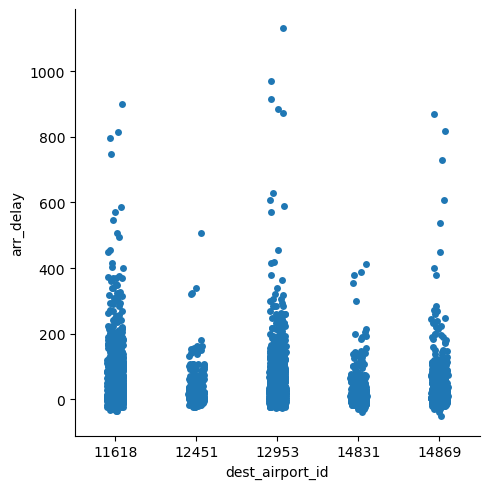

In [106]:
# visualizing the trends of the top 5 airports on dep_delay

top5airports = df['dest_airport_id'].unique()[:5]
filter = df['dest_airport_id'].isin(top5airports)
df_top_5_airports_df = df[(filter)]
sns.catplot(data=df_top_5_airports_df, x="dest_airport_id", y="arr_delay")
plt.show()

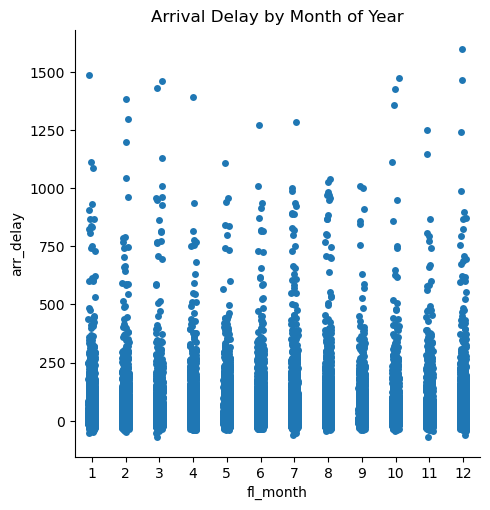

In [108]:
df_ = df.copy()
df_['fl_month'] = pd.to_datetime(df_['fl_date']).dt.month
sns.catplot(data=df_, x="fl_month", y="arr_delay")
plt.title('Arrival Delay by Month of Year')
plt.show()

**Observations**:

- There are several categorical features that will be important - origin and destination, plane tail_num, branded code share (which tells us if two carriers are sharing responsibility for a flight, etc). tail_num, for

- Strategy - use these features as dimensions for `groupby` to aggregate numerical features over, and join the new datasets into the main df, and thereby substituting the categorical features with as much unique information as possible.

- Based off EDA analysis and general knowledge aboutairport traffic, the key dimensions to aggregate would be:

`tail_num`, `origin_aiport_id`, `dest_airport_id` (separately and as paired routes), as well extracted features like `dayofweek`, `dep_hour`, `arr_hour`, `fl_month` (which should give some seasonal data).

In [30]:
def tailnum_delay_taxi_multiclass_params(df_sample):
    """
    Input: flights csv sample or full dataset AFTER preprocessing_dataset
    Aggregates on tail_num
    Output: 
        index / join key: 'tail_num'
        columns: aggregated isCraft and isCarrier delays 
    """  
    
    df_sample['isCraft'] = df_sample['target_delay'].\
                            apply (lambda x: 1 if x == 'late_aircraft_delay' else 0)
    df_sample['isCarrier'] = df_sample['target_delay'].\
                            apply (lambda x: 1 if x == 'carrier_delay' else 0)

    tailnum_delay_taxi_df = df_sample.groupby('tail_num').agg({'dep_delay': 'median',
                                  'arr_delay' : 'median',
                                  'isCraft' : 'mean',
                                  'isCarrier' : 'mean'      
                                  })
    return tailnum_delay_taxi_df   

tailnum_delay_taxi_multiclass_params(df.copy()).head()

,dep_delay,arr_delay,isCraft,isCarrier
tail_num,,,,
215NV,31.5,30.0,0.400000,0.500000
216NV,11.0,18.0,0.181818,0.636364
217NV,17.5,14.0,0.250000,0.625000
218NV,23.0,31.0,0.384615,0.461538
219NV,30.0,16.0,0.285714,0.714286


In [33]:
def tailnum_hourly_delays_multiclass_params(df_sample):
    """
    Input: flights csv sample or full dataset AFTER preprocessing_dataset
    Aggregates on tail_num and arr_hour and tail_num and dep_hour
    Output: 2 dataframes 
        index / join key: 'tail_num' and arr_hour / dep_hour
        columns: median delays
    """  
    df_sample['isCraft'] = df_sample['target_delay'].\
                            apply (lambda x: 1 if x == 'late_aircraft_delay' else 0)
    df_sample['isCarrier'] = df_sample['target_delay'].\
                            apply (lambda x: 1 if x == 'carrier_delay' else 0)
    
    # extract hour and minute from crs_time
    df_sample['dep_hour'] = (np.round(df_sample['crs_dep_time'],-2)/100).astype(int)
    df_sample['arr_hour'] = (np.round(df_sample['crs_arr_time'],-2)/100).astype(int)
    
    tailnum_dep_hourly_delays_df = df_sample.groupby(['tail_num', 'dep_hour']).agg({'dep_delay': 'median',
                                          'carrier_delay' :  'median',
                                          'late_aircraft_delay' :  'median',
                                          'isCraft' : 'mean', 
                                          'isCarrier' : 'mean' })
    tailnum_arr_hourly_delays_df = df_sample.groupby(['tail_num', 'arr_hour']).agg({'arr_delay': 'median',
                                          'carrier_delay' :  'median',
                                          'late_aircraft_delay' :  'median',
                                          'isCraft' : 'mean', 
                                          'isCarrier' : 'mean' })
    
    return tailnum_dep_hourly_delays_df, tailnum_arr_hourly_delays_df

dep, arr =  tailnum_hourly_delays_multiclass_params(df.copy())
dep.head()

dep_delay  carrier_delay  late_aircraft_delay  isCraft  \
tail_num dep_hour                                                           
215NV    6               7.0            0.0                  0.0      0.0   
         13             63.0           14.0                 41.0      1.0   
         14             50.0           45.0                  0.0      0.0   
         15              7.0            0.0                  0.0      0.0   
         16            193.0            0.0                189.0      1.0   

                   isCarrier  
tail_num dep_hour             
215NV    6          0.666667  
         13         0.000000  
         14         1.000000  
         15         1.000000  
         16         0.000000

In [34]:
arr.head()

arr_delay  carrier_delay  late_aircraft_delay  isCraft  \
tail_num arr_hour                                                           
215NV    7              15.0            7.0                  0.0      0.0   
         8               6.0            0.0                  0.0      0.0   
         9               0.0            0.0                  0.0      0.0   
         15             55.0           14.0                 41.0      1.0   
         17            117.0           22.5                 94.5      0.5   

                   isCarrier  
tail_num arr_hour             
215NV    7               0.0  
         8               1.0  
         9               1.0  
         15              0.0  
         17              0.5

In [35]:
def carrier_branded_dayofweek_delay_multiclass_params(df_sample):
    """
    Input: flights csv sample or full dataset AFTER preprocessing_dataset
    Aggregates on op_unique_carrier, branded_share, f1_dayofweek
    
    Output: 
        index /join key: op_unique_carrier, branded_share, f1_dayofweek
        columns: median delays and isCarrier
    """      
    

    df_sample['branded_share'] = df_sample['branded_code_share'].apply(lambda x: 1 if len(x)>2 else 0)
    df_sample = df_sample.drop(columns = ['branded_code_share'])
    
    
    df_sample['isCarrier'] = df_sample['target_delay'].\
                            apply (lambda x: 1 if x == 'carrier_delay' else 0)


    df_sample['fl_date'] = pd.to_datetime(df_sample['fl_date'])
    df_sample['fl_dayofweek'] = df_sample['fl_date'].dt.dayofweek
    df_sample.drop(columns=['fl_date'], inplace=True)


    carrier_df = df_sample.groupby(['op_unique_carrier', 'branded_share', 'fl_dayofweek'])\
                                    .agg({'dep_delay': 'median',
                                          'arr_delay' : 'median',
                                          'carrier_delay' :  'median',
                                          'late_aircraft_delay' :  'median', 
                                          'isCarrier' : 'mean' })
    return carrier_df
carrier_branded_dayofweek_delay_multiclass_params(df.copy()).head()

dep_delay  arr_delay  \
op_unique_carrier branded_share fl_dayofweek                         
9E                1             0                  15.5       19.5   
                                1                  17.0       17.5   
                                2                  14.0       14.5   
                                3                  14.0       16.5   
                                4                  15.0       16.0   

                                              carrier_delay  \
op_unique_carrier branded_share fl_dayofweek                  
9E                1             0                       0.0   
                                1                       0.0   
                                2                       0.0   
                                3                       0.0   
                                4                       0.0   

                                              late_aircraft_delay  isCarrier  
op_unique_carrier branded_share fl_dayofweek                                  
9E                1             0                             0.0   0.594406  
                                1                             0.0   0.633466  
                                2                             0.0   0.633588  
                                3                             0.0   0.560811  
                                4                             0.0   0.586310

In [36]:
def dest_monthly_multiclass_params(df_sample):
    """
    Input: flights csv sample or full dataset AFTER preprocessing_dataset
    Aggregates on dest_airport_id, fl_month
    
    Output: 2 dataframes 
        index / join key: dest_airport_id, fl_month
        columns: median delays and isWeather, isSecurity
    """   

    # extract hour and minute from crs_time
    df_sample['fl_date'] = pd.to_datetime(df_sample['fl_date'])
    df_sample['fl_month'] = df_sample['fl_date'].dt.month
    
    df_sample['isWeather'] = df_sample['target_delay'].\
                            apply (lambda x: 1 if x == 'weather_delay' else 0)
    df_sample['isSecurity'] = df_sample['target_delay'].\
                            apply (lambda x: 1 if x == 'security_delay' else 0)

    
    dest_monthly_params = df_sample.groupby(['dest_airport_id', 'fl_month']).agg({'arr_delay': 'median',
                                  'arr_delay' : 'median',
                                  'carrier_delay': 'median',  
                                  'nas_delay': 'median', 
                                  'late_aircraft_delay': 'median',                                    
                                  'weather_delay' : 'median',
                                  'security_delay' : 'median', 
                                  'isWeather' : 'mean' , 
                                  'isSecurity' : 'mean' ,
                                                                                  
                                  })
    
    dest_monthly_params.index.to_flat_index()
    return dest_monthly_params
dest_monthly_multiclass_params(df.copy()).head()

arr_delay  carrier_delay  nas_delay  \
dest_airport_id fl_month                                        
10135           1             147.0            0.0        1.0   
                2               5.0            0.0        0.0   
                3              11.0            0.0        0.0   
                4               1.0            0.0        0.0   
                5               8.0            0.0        0.0   

                          late_aircraft_delay  weather_delay  security_delay  \
dest_airport_id fl_month                                                       
10135           1                        28.0            0.0             0.0   
                2                         0.0            0.0             0.0   
                3                         0.0            0.0             0.0   
                4                         0.0            0.0             0.0   
                5                         0.0            0.0             0.0   

                          isWeather  isSecurity  
dest_airport_id fl_month                         
10135           1               0.0         0.0  
                2               0.0         0.0  
                3               0.0         0.0  
                4               0.0         0.0  
                5               0.0         0.0

In [37]:
def origin_monthly_multiclass_params(df_sample):
    """
    Input: flights csv sample or full dataset AFTER preprocessing_dataset
    Aggregates on origin_airport_id, fl_month
          
    Output: A dataframe
        index / join key: 'origin_airport_id', 'fl_month'
        columns: median delays and isWeather, isSecurity
    """
    

    # extract hour and minute from crs_time
    df_sample['fl_date'] = pd.to_datetime(df_sample['fl_date'])
    df_sample['fl_month'] = df_sample['fl_date'].dt.month

    df_sample['isWeather'] = df_sample['target_delay'].\
                            apply (lambda x: 1 if x == 'weather_delay' else 0)
    df_sample['isSecurity'] = df_sample['target_delay'].\
                            apply (lambda x: 1 if x == 'security_delay' else 0)
    
    origin_monthly_params = df_sample.groupby(['origin_airport_id', 'fl_month']).agg({'dep_delay': 'median',
                                  'arr_delay' : 'median',
                                  'carrier_delay': 'median',  
                                  'nas_delay': 'median', 
                                  'late_aircraft_delay': 'median',                                    
                                  'weather_delay' : 'median',
                                  'security_delay' : 'median', 
                                  'isWeather' : 'mean', 
                                  'isSecurity' : 'mean',
                                  })
    
    origin_monthly_params.index.to_flat_index()
    return origin_monthly_params
origin_monthly_multiclass_params(df.copy()).head()

dep_delay  arr_delay  carrier_delay  nas_delay  \
origin_airport_id fl_month                                                   
10135             1               3.0        3.0            0.0        0.0   
                  2              49.0       46.0            2.0        0.0   
                  3               5.0       12.0            0.0        0.0   
                  4              29.5       21.0            0.0        6.5   
                  5              56.0       50.0            0.0        0.0   

                            late_aircraft_delay  weather_delay  \
origin_airport_id fl_month                                       
10135             1                         0.0            0.0   
                  2                        44.0            0.0   
                  3                         0.0            0.0   
                  4                        17.0            0.0   
                  5                         0.0            0.0   

                            security_delay  isWeather  isSecurity  
origin_airport_id fl_month                                         
10135             1                    0.0   0.000000         0.0  
                  2                    0.0   0.000000         0.0  
                  3                    0.0   0.000000         0.0  
                  4                    0.0   0.000000         0.0  
                  5                    0.0   0.142857         0.0

In [38]:
def origin_dest_route_dayofweek_multiclass_params(df_sample):
    """
    Input: flights csv sample or full dataset AFTER preprocessing_dataset
    Aggregates on 'origin_airport_id', 'dest_airport_id', 'fl_dayofweek'
    
    Output: A dataframe
        Index: 'origin_airport_id', 'dest_airport_id', 'fl_dayofweek'
        columns: median delays, isCarrier
    """
    
    df_sample['isCarrier'] = df_sample['target_delay'].\
                            apply (lambda x: 1 if x == 'carrier_delay' else 0)
    
    # get dayofweek
    df_sample['fl_date'] = pd.to_datetime(df_sample['fl_date'])
    df_sample['fl_dayofweek'] = df_sample['fl_date'].dt.dayofweek
    # traffic
    
    params_df = df_sample.groupby(['origin_airport_id', 'dest_airport_id', 
                                   'fl_dayofweek']).agg({'dep_delay': 'median',
                              'arr_delay' : 'median',
                              'carrier_delay': 'median',  
                              'nas_delay': 'median', 
                              'late_aircraft_delay': 'median',                                    
                              'weather_delay' : 'median',
                              'security_delay' : 'median',
                              'isCarrier' : 'mean'
                              })

    params_df['traffic'] = df_sample.groupby(['origin_airport_id', 'dest_airport_id', 'fl_dayofweek']).size()
    
    
    return params_df
origin_dest_route_dayofweek_multiclass_params(df.copy()).head()

dep_delay  arr_delay  \
origin_airport_id dest_airport_id fl_dayofweek                         
10135             10397           0                   2.0       15.0   
                                  2                  25.0        2.0   
                                  4                  12.0       28.0   
                                  6                   5.0        1.0   
                  11057           0                  -4.0       12.0   

                                                carrier_delay  nas_delay  \
origin_airport_id dest_airport_id fl_dayofweek                             
10135             10397           0                       0.0       10.5   
                                  2                       0.0        0.0   
                                  4                      12.0       16.0   
                                  6                       0.0        0.0   
                  11057           0                       0.0        0.0   

                                                late_aircraft_delay  \
origin_airport_id dest_airport_id fl_dayofweek                        
10135             10397           0                             0.0   
                                  2                             0.0   
                                  4                             0.0   
                                  6                             0.0   
                  11057           0                             0.0   

                                                weather_delay  security_delay  \
origin_airport_id dest_airport_id fl_dayofweek                                  
10135             10397           0                       0.0             0.0   
                                  2                       0.0             0.0   
                                  4                       0.0             0.0   
                                  6                       0.0             0.0   
                  11057           0                       0.0             0.0   

                                                isCarrier  traffic  
origin_airport_id dest_airport_id fl_dayofweek                      
10135             10397           0              0.500000        2  
                                  2              0.666667        3  
                                  4              0.000000        1  
                                  6              1.000000        1  
                  11057           0              1.000000        1

### Further feature engineering:

Holidays are usually periods of peak traffic, and it would be useful to track how delays are impacted during this time. 

In [91]:
us_holidays_df = pd.read_csv('../extra/us_holidays.csv')
us_holidays_df

,date,holidays
0,2018-01-01,New Year
1,2018-05-28,Memorial Day
2,2018-07-04,Independence Day
3,2018-09-03,Labor Day
4,2018-11-22,Thanksgiving
5,2018-12-25,Christmas
6,2019-01-01,New Year
7,2019-05-27,Memorial Day
8,2019-07-04,Independence Day
9,2019-09-02,Labor Day


In [93]:
def holiday_multiclass_params(df_sample):
    """
    Input: flights csv sample or full dataset AFTER preprocessing_dataset
    Aggregates on 'holidate', 'origin_airport_id', 'dest_airport_id'
    Output: 
        Index / join key: 'holidate', 'origin_airport_id', 'dest_airport_id'
        columns: median delays,  isWeather isSecurity

    """
       
        
########################################
##  run this if holidays is not available. check the file location first
    us_holidays_df = pd.read_csv('../extra/us_holidays.csv')

    from datetime import timedelta
    holidays = []
    for hol in us_holidays_df['date'].values:
        holstart = pd.to_datetime(hol) - timedelta(days=3)
        holend = pd.to_datetime(hol) + timedelta(days=3)
        holidayweek = pd.date_range(holstart, holend)
        holidays.extend(holidayweek)
#######################
    
    df_sample['isWeather'] = df_sample['target_delay'].\
                            apply (lambda x: 1 if x == 'weather_delay' else 0)
    df_sample['isSecurity'] = df_sample['target_delay'].\
                            apply (lambda x: 1 if x == 'security_delay' else 0)

    
    # get holidate 
    df_sample['fl_date'] = pd.to_datetime(df_sample['fl_date'])
    df_sample['holidate'] = df_sample['fl_date'].apply(lambda x: 1 if x in holidays else 0)


    holiday_params = df_sample.groupby(['holidate', 'origin_airport_id', 'dest_airport_id']).agg({'dep_delay': 'median',
                              'arr_delay' : 'median',
                              'carrier_delay': 'median',  
                              'nas_delay': 'median', 
                              'late_aircraft_delay': 'median',                                    
                              'weather_delay' : 'median',
                              'security_delay' : 'median',
                              'isWeather' : 'mean', 
                              'isSecurity' : 'mean',
                              })
    
    return holiday_params
holiday_multiclass_params(df).head()        

dep_delay  arr_delay  \
holidate origin_airport_id dest_airport_id                         
0        10135             10397                  5.0        9.0   
                           11057                  7.0       15.0   
                           11433                  9.0       12.0   
                           13930                  1.0        5.0   
                           14082                 89.0       97.0   

                                            carrier_delay  nas_delay  \
holidate origin_airport_id dest_airport_id                             
0        10135             10397                      0.0        0.0   
                           11057                      0.0        0.0   
                           11433                      0.0        0.0   
                           13930                      0.0        0.0   
                           14082                      0.0        0.0   

                                            late_aircraft_delay  \
holidate origin_airport_id dest_airport_id                        
0        10135             10397                            0.0   
                           11057                            0.0   
                           11433                            0.0   
                           13930                            0.0   
                           14082                            0.0   

                                            weather_delay  security_delay  \
holidate origin_airport_id dest_airport_id                                  
0        10135             10397                      0.0             0.0   
                           11057                      0.0             0.0   
                           11433                      0.0             0.0   
                           13930                      0.0             0.0   
                           14082                      0.0             0.0   

                                            isWeather  isSecurity  
holidate origin_airport_id dest_airport_id                         
0        10135             10397             0.142857         0.0  
                           11057             0.000000         0.0  
                           11433             0.000000         0.0  
                           13930             0.000000         0.0  
                           14082             0.000000         0.0

In [105]:
df.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,dest_airport_id,crs_dep_time,dep_delay,crs_arr_time,arr_delay,crs_elapsed_time,air_time,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,target_delay
1,2019-05-25,AS,AS,AS,1438,AS,N844VA,1438,12892,14831,2005,53.0,2130,53.0,85.0,55.0,308,16.0,0.0,0.0,0.0,37.0,late_aircraft_delay
5,2018-07-22,AA,AA_CODESHARE,AA,3499,MQ,N820AE,3499,11066,12953,910,10.0,1100,9.0,110.0,82.0,479,0.0,0.0,0.0,0.0,0.0,carrier_delay
7,2019-11-27,WN,WN,WN,892,WN,N465WN,892,10397,12451,1955,16.0,2100,11.0,65.0,43.0,270,0.0,0.0,0.0,0.0,0.0,carrier_delay
10,2019-01-10,UA,UA,UA,2342,UA,N834UA,2342,14492,11618,1805,149.0,1957,149.0,112.0,71.0,416,0.0,0.0,149.0,0.0,0.0,nas_delay
12,2019-11-20,DL,DL,DL,1142,DL,N847DN,1142,14057,14869,1858,-6.0,2145,16.0,107.0,91.0,630,0.0,0.0,16.0,0.0,0.0,nas_delay


* Part of the strategy was to put the features functions into scripts that can then be called from other notebooks.

- `../../py_scripts/dataset_processing.py`

- `../../py_scripts/feature_generation_for_multiclass.py`

- `../../training_and_testing_prep.py`